In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## collab user
# !pip install neuron
# !pip install netpyne
# !git clone https://github.com/suny-downstate-medical-center/S1_netpyne.git
# import os
# os.chdir('S1_netpyne/info')

In [3]:
import matplotlib
import os
os.chdir('../sim')

In [4]:
!nrnivmodl mod/

/home/fernando/S1_netpyne/sim
Mod files: "mod/cadad.mod" "mod/CaDynamics_E2.mod" "mod/Ca_HVA.mod" "mod/Ca_LVAst.mod" "mod/Ca.mod" "mod/DetAMPANMDA.mod" "mod/DetGABAAB.mod" "mod/HH2.mod" "mod/htc.mod" "mod/Ih.mod" "mod/Im.mod" "mod/IT2.mod" "mod/IT.mod" "mod/KdShu2007.mod" "mod/kl.mod" "mod/K_Pst.mod" "mod/K_Tst.mod" "mod/MyExp2SynBB.mod" "mod/MyExp2SynNMDABB.mod" "mod/Nap_Et2.mod" "mod/NaTa_t.mod" "mod/NaTs2_t.mod" "mod/ProbAMPANMDA_EMS.mod" "mod/ProbGABAAB_EMS.mod" "mod/SK_E2.mod" "mod/SKv3_1.mod" "mod/StochKv_deterministic.mod" "mod/StochKv.mod" "mod/tia.mod" "mod/vecevent.mod"

COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/home/fernando/anaconda3/envs/netpynedev/lib/python3.7/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
g++ -O2 -DVERSION_INFO='8.0.0' -std=c++11 -shared -fPIC  -I /home/fernando/anaconda3/envs/netpynedev/lib/python3.7/site-packages/neuron/.data/include -o ./libnrnmec

In [5]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np

%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 2.0*1e2 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 4321, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True

cfg.checkErrors = False

cfg.poptypeNumber = 55
cfg.celltypeNumber = 207

In [6]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop
with open('../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
	mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
cfg.popLabelEl = {} 
for line in mtype_content.split('\n')[:-1]:
	metype, mtype, etype, n, m = line.split()
	cfg.cellNumber[metype] = int(n)
	cfg.popLabel[metype] = mtype
	cfg.popNumber[mtype] = int(m)

	if mtype not in popParam:
		popParam.append(mtype)
		cfg.popLabelEl[mtype] = [] 
               
	cfg.popLabelEl[mtype].append(metype)
	cellParam.append(metype)

cfg.S1pops = popParam[0:55]
cfg.S1cells = cellParam[0:207]

#------------------------------------------------------------------------------  
cfg.popParamLabels = popParam[0:cfg.poptypeNumber] # to debug
cfg.cellParamLabels = cellParam[0:cfg.celltypeNumber] # to debug

In [7]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------

# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = False    

# TO DEBUG - Create only 5 Cells for each MEtype in S1
cfg.oneCellperMEtypeS1 = False 

In [8]:
#------------------------------------------------------------------------------  
# TO DEBUG - Create only one Cell per MEtype in S1 cells
if cfg.oneCellperMEtypeS1:
	cfg.popNumber = {}
	cfg.cellNumber = {} 
	for mtype in cfg.S1pops:
		cfg.popNumber[mtype] = 0

	for line in mtype_content.split('\n')[:-1]:
		metype, mtype, etype, n, m = line.split()
		if int(n) < 5:
			cfg.cellNumber[metype] = int(n)
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + int(n)
		else:
			cfg.cellNumber[metype] = 5
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + 5


In [9]:
# testpop = ['L4_SS', 'L5_STPC', 'L5_UTPC', 'L23_LBC', 'L23_MC', 'L4_LBC', 'L4_MC', 'L5_LBC', 'L5_MC']
# Nsyn=513042, N=2684

In [10]:
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

In [11]:
subPopLabels = [] # 
popNumberLabel = 0 
for mtype in cfg.S1pops[28:42]:
    if cfg.popNumber[mtype] < 400:
        popNumberLabel += cfg.popNumber[mtype] 
        subPopLabels.append(mtype)
        print(mtype,cfg.popNumber[mtype])
        
popNumberLabel

L5_BP 34
L5_BTC 76
L5_ChC 19
L5_DBC 96
L5_LBC 210
L5_MC 395
L5_NBC 201
L5_NGC 8
L5_SBC 25
L5_STPC 302
L5_UTPC 342


1708

In [12]:
# subPopLabels = ['L4_MC', 'L5_LBC', 'L5_STPC'] # 
#------------------------------------------------------------------------------  
cfg.S1pops = subPopLabels
cfg.S1cells = []
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:        
        cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells

In [13]:
cellsID = {}    
cellNumberLabel = 0 
for mtype in cfg.S1pops:
    for metype in cfg.popLabelEl[mtype]:
        print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])    
        cellsID[metype] = [ids for ids in range(cellNumberLabel,cellNumberLabel+cfg.cellNumber[metype])]
        cellNumberLabel += cfg.cellNumber[metype]   

L5_BP_bAC217 3 L5_BP 34
L5_BP_bIR215 5 L5_BP 34
L5_BP_bNAC219 9 L5_BP 34
L5_BP_cACint209 9 L5_BP 34
L5_BP_cNAC187 5 L5_BP 34
L5_BP_dSTUT214 3 L5_BP 34
L5_BTC_bAC217 13 L5_BTC 76
L5_BTC_cACint209 50 L5_BTC 76
L5_BTC_cNAC187 13 L5_BTC 76
L5_ChC_cACint209 7 L5_ChC 19
L5_ChC_cNAC187 7 L5_ChC 19
L5_ChC_dNAC222 5 L5_ChC 19
L5_DBC_bAC217 9 L5_DBC 96
L5_DBC_bIR215 34 L5_DBC 96
L5_DBC_bNAC219 9 L5_DBC 96
L5_DBC_bSTUT213 9 L5_DBC 96
L5_DBC_cACint209 9 L5_DBC 96
L5_DBC_cIR216 17 L5_DBC 96
L5_DBC_cNAC187 9 L5_DBC 96
L5_LBC_bAC217 12 L5_LBC 210
L5_LBC_cACint209 25 L5_LBC 210
L5_LBC_cIR216 13 L5_LBC 210
L5_LBC_cNAC187 37 L5_LBC 210
L5_LBC_cSTUT189 37 L5_LBC 210
L5_LBC_dNAC222 37 L5_LBC 210
L5_LBC_dSTUT214 49 L5_LBC 210
L5_MC_bAC217 145 L5_MC 395
L5_MC_bIR215 44 L5_MC 395
L5_MC_bSTUT213 16 L5_MC 395
L5_MC_cACint209 142 L5_MC 395
L5_MC_cNAC187 16 L5_MC 395
L5_MC_cSTUT189 16 L5_MC 395
L5_MC_dNAC222 16 L5_MC 395
L5_NBC_bAC217 14 L5_NBC 201
L5_NBC_bIR215 14 L5_NBC 201
L5_NBC_bSTUT213 27 L5_NBC 201
L5_NBC

In [14]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.popParamLabels
cfg.cellsrec = 0
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype (cfg.celldiversity = True)
	cfg.recordCells = []
	cellNumberLabel = 0 
	for metype in cfg.cellParamLabels:
		if metype in cfg.cellParamLabels:
			if cfg.cellNumber[metype] < 5:
				for numberME in range(cfg.cellNumber[metype]):
					cfg.recordCells.append((cfg.popLabel[metype],cellNumberLabel+numberME))
			else:
				for numberME in range(0,cfg.cellNumber[metype],int(cfg.cellNumber[metype]/4.5)):
					cfg.recordCells.append((cfg.popLabel[metype],cellNumberLabel+numberME))
			cellNumberLabel = cellNumberLabel + cfg.cellNumber[metype]
			if cellNumberLabel == cfg.popNumber[cfg.popLabel[metype]]:
				cellNumberLabel = 0 
                
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False			
cfg.recordTime = False  		
cfg.recordStep = 0.1    

In [15]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'subNets_test0'
cfg.saveFolder = '../info/test/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = True	           	## Save json file
cfg.saveDataInclude = ['simConfig','simData'] ## , 'netParams', 'simConfig', 
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			
cfg.saveCellConns = True	

In [16]:
"""
netParams.py
"""
# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 420.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 2082.0 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 420.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume

# r = 210 um and hexagonal side length = 230.9 um

In [17]:
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	


cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries


In [18]:
#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)(M1: 2.0 ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)(M1: 500.0um/ms)
netParams.scaleConnWeight = 0.001 # weight conversion factor (from nS to uS)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

In [19]:
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
## S1
cfg.scaleDensity = 1.0

for popName in cfg.S1pops:
	layernumber = popName[1:2]
	if layernumber == '2':
		netParams.popParams[popName] = {'cellType': popName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.popNumber[popName])), 'diversity': True}
	else:
		netParams.popParams[popName] = {'cellType': popName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.popNumber[popName])), 'diversity': True}

In [20]:
## S1 cell property rules
cellnumber = 0    
for cellName in cfg.S1cells:
    
    if cfg.cellNumber[cellName] < 5:
        morphoNumbers = cfg.cellNumber[cellName]
    else:
        morphoNumbers = 5
    
    popName = cfg.popLabel[cellName]
    cellFraction = 1.0*cfg.cellNumber[cellName]/(morphoNumbers*cfg.popNumber[popName])
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cellName + '_' + str(morphoNumber+1)
        ## Load cell rules previously saved using netpyne format
        netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/' + cellMe + '/' + cellMe + '_cellParams.pkl')    
        netParams.renameCellParamsSec(label = cellMe, oldSec = 'soma_0', newSec = 'soma')

        cellRule = {'conds': {'cellType': popName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
        cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
        cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
        cellRule['conds']['cellType'] = popName
        cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
        cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']                 
        cellRule['secLists']['all'][0] = 'soma' # replace 'soma_0'
        cellRule['secLists']['somatic'][0]  = 'soma' # replace 'soma_0'
                              
        cellRule['secLists']['spiny'] = {}
        cellRule['secLists']['spinyEE'] = {}

        nonSpiny = ['axon_0', 'axon_1']
        cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
        nonSpinyEE = ['axon_0', 'axon_1', 'soma']
        cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]

        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secLists']['spiny'] = ['soma']
            cellRule['secLists']['spinyEE'] = ['soma']
            cellRule['secLists']['all'] = ['soma']
            cellRule['secLists']['basal'] = ['soma']    
        #-----------------------------------------------------------------------------------#
        netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
        cellnumber=cellnumber+1

In [21]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from M1 detailed
#------------------------------------------------------------------------------
## S1
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['NMDA'] = {'mod': 'MyExp2SynNMDABB', 'tau1NMDA': 0.29, 'tau2NMDA': 43, 'e': 0}
netParams.synMechParams['GABAA6'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 6.44, 'e': -80}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}
netParams.synMechParams['GABAA10'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 10.4, 'e': -80}
netParams.synMechParams['GABAB'] = {'mod':'MyExp2SynBB', 'tau1': 3.5, 'tau2': 260.9, 'e': -93} 

ESynMech = ['AMPA', 'NMDA']
ISynMech = ['GABAA', 'GABAB']
ISynMech6 = ['GABAA6', 'GABAB']
ISynMech10 = ['GABAA10', 'GABAB']

In [22]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']

a0e = connData['a0mat_exp']
l0e = connData['lmat_exp']
d0e = connData['d0_exp']

a0g = connData['a0mat_gauss']
x0g = connData['x0_gauss']
l0g = connData['lmat_gauss']
d0g = connData['d0_gauss']

dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

In [23]:
import pandas as pd

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
#     print(name,syntype,parameters_syn[name,syntype])
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.55,10.4,6.1,0.16,0.1,45,21,376,253,I1,II
3,1,0.91,0.61,10.4,6.1,0.16,0.1,45,21,376,253,I1,IE
13,2,0.75,0.32,10.4,6.1,0.415,0.212,162,69,690,5,I1,IE
1,3,0.83,0.55,8.3,2.2,0.25,0.13,706,405,21,9,I2,II
4,4,0.91,0.61,8.3,2.2,0.25,0.13,706,405,21,9,I2,IE
8,5,0.75,0.32,8.3,2.2,0.25,0.13,706,405,21,9,I2,IE
9,6,0.75,0.32,8.3,2.2,0.3,0.08,1250,520,2,4,I2,IE
10,7,0.91,0.61,8.3,2.2,0.14,0.05,875,285,22,5,I2,IE
12,8,2.97,0.95,8.3,2.2,0.25,0.13,706,405,21,9,I2,IE
5,9,0.91,0.61,6.44,1.7,0.32,0.14,144,80,62,31,I3,IE


In [24]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from S1 BBP - deterministic version
#------------------------------------------------------------------------------
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA  ?          
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }

In [25]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

if cfg.addConn:    
    for pre in Ipops+Epops:
        for post in Ipops+Epops:
            if float(connNumber[pre][post]) > 0:          
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    # single fit
                    if 'exp' in connData['best_fit'][pre][post]:  # exponential            
                        prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])      
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])   
                        
                else:
                    if 'expl' in connData['best_fit'][pre][post]:  # exponential + linear interpolation [25:d0]
                        if int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],float(pmat[12.5][pre][post]))
                        else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                            d01 = int(float(d0[pre][post]))
                            y1 = float(pmat[25][pre][post])
                            y2 = float(pmat[d01][pre][post])
                            x1 = 25
                            x2 = d01                   
                            angular = (y2 - y1)/(x2 - x1)
                            linear = y2 - x2*angular
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                   
                    elif 'exp' in connData['best_fit'][pre][post]:  # exponential     
                        if float(pmat[12.5][pre][post]) > float(pmat[25][pre][post]):
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post])
                        else:  
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post],d0e[pre][post],float(pmat[12.5][pre][post]))      
                    
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])             
                        
                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        netParams.connParams['II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': pre}, 
                                        'postConds': {'pop': post},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}        
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:    
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                
                                for preetype in connIEtype[premtype].keys():
                                    if preetype in cellpre:
                                        connID = connIEtype[premtype][preetype]    
                                        print(preetype,cellpre,connID)
                                                                 
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A += cellsID[cellpre]    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B += cellsID[cellpre]
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C += cellsID[cellpre]
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR I -> E')    
                            
                            connID = ConnTypes[pre][post][0]                            
                            synMechType = 'S1_IE_STP_Det_' + str(connID)                       
                            netParams.connParams['IE_'+pre+'_'+post] = { 
                                        'preConds': {'pop': pre, 'cellList': cellpreList_A}, 
                                        'postConds': {'pop': post},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}  


                            if connID_B >= 0:          
                                connID = connID_B
                                synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': pre, 'cellList': cellpreList_B}, 
                                            'postConds': {'pop': post},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       


                                if connID_C >= 0:          
                                    connID = connID_C
                                    synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                    netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
                                                'preConds': {'pop': pre, 'cellList': cellpreList_C}, 
                                                'postConds': {'pop': post},
                                                'synMech': synMechType,
                                                'probability': prob,
                                                'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                                'synMechWeightFactor': cfg.synWeightFractionIE,
                                                'delay': 'defaultDelay+dist_3D/propVelocity',
                                                'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                                'sec': 'spiny'}                       
                                          
                        else:   
                            connID = ConnTypes[pre][post][0]                            
                            synMechType = 'S1_IE_STP_Det_' + str(connID)
                            
                            netParams.connParams['IE_'+pre+'_'+post] = { 
                                        'preConds': {'pop': pre}, 
                                        'postConds': {'pop': post},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}  
                            

                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in Epops:
                    if post in Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        netParams.connParams['EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': pre}, 
                            'postConds': {'pop': post},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'}    
    
                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in Epops:
                    if post in Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            connID = ConnTypes[pre][post][0]      
                            synMechType = 'S1_EI_STP_Det_' + str(connID)                        
                            netParams.connParams['EI_'+pre+'_'+post] = { 
                                            'preConds': {'pop': pre}, 
                                            'postConds': {'pop': post},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   
                            
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:   
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]   
                                
                                for postetype in connEItype[postmtype].keys():
                                    if postetype in cellpost:
                                        connID = connEItype[postmtype][postetype]    
                                        print(postetype,cellpost,connID)
                                                                 
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A += cellsID[cellpost]    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B += cellsID[cellpost]
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR E -> I')                 
                             
                            connID = ConnTypes[pre][post][0]      
                            synMechType = 'S1_EI_STP_Det_' + str(connID)                       
                            netParams.connParams['EI_'+pre+'_'+post] = { 
                                            'preConds': {'pop': pre}, 
                                            'postConds': {'pop': post, 'cellList': cellpostList_A},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   

                            if connID_B >= 0:          
                                connID = connID_B
                                synMechType = 'S1_EI_STP_Det_' + str(connID)        
                                netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
                                                'preConds': {'pop': pre}, 
                                                'postConds': {'pop':post, 'cellList': cellpostList_B},
                                                'synMech': synMechType,
                                                'probability': prob, 
                                                'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                                'synMechWeightFactor': cfg.synWeightFractionEI,
                                                'delay': 'defaultDelay+dist_3D/propVelocity',
                                                'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                                'sec': 'spiny'}   
                            
                                             
                        else:                           
                            connID = ConnTypes[pre][post][0]      
                            synMechType = 'S1_EI_STP_Det_' + str(connID)                        
                            netParams.connParams['EI_'+pre+'_'+post] = { 
                                            'preConds': {'pop': pre}, 
                                            'postConds': {'pop': post},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}    

bAC L5_LBC_bAC217 10
cAC L5_LBC_cACint209 10
cIR L5_LBC_cIR216 10
cNA L5_LBC_cNAC187 5
cST L5_LBC_cSTUT189 5
dNA L5_LBC_dNAC222 10
dST L5_LBC_dSTUT214 5
bAC L5_LBC_bAC217 10
cAC L5_LBC_cACint209 10
cIR L5_LBC_cIR216 10
cNA L5_LBC_cNAC187 5
cST L5_LBC_cSTUT189 5
dNA L5_LBC_dNAC222 10
dST L5_LBC_dSTUT214 5
bAC L5_NBC_bAC217 10
bIR L5_NBC_bIR215 10
bST L5_NBC_bSTUT213 5
cAC L5_NBC_cACint209 10
cIR L5_NBC_cIR216 10
cNA L5_NBC_cNAC187 5
cST L5_NBC_cSTUT189 5
dST L5_NBC_dSTUT214 5
bAC L5_NBC_bAC217 10
bIR L5_NBC_bIR215 10
bST L5_NBC_bSTUT213 5
cAC L5_NBC_cACint209 10
cIR L5_NBC_cIR216 10
cNA L5_NBC_cNAC187 5
cST L5_NBC_cSTUT189 5
dST L5_NBC_dSTUT214 5
bNA L5_SBC_bNAC219 5
cAC L5_SBC_cACint209 3
dNA L5_SBC_dNAC222 4
bNA L5_SBC_bNAC219 5
cAC L5_SBC_cACint209 3
dNA L5_SBC_dNAC222 4
bAC L5_BP_bAC217 117
bIR L5_BP_bIR215 117
bNA L5_BP_bNAC219 117
cAC L5_BP_cACint209 114
cNA L5_BP_cNAC187 117
dST L5_BP_dSTUT214 117
bAC L5_BTC_bAC217 117
cAC L5_BTC_cACint209 114
cNA L5_BTC_cNAC187 117
bAC L5_DBC_bA

In [26]:
netParams.connParams.keys()

odict_keys(['II_L5_BP_L5_BTC', 'II_L5_BP_L5_LBC', 'II_L5_BP_L5_MC', 'II_L5_BP_L5_NBC', 'IE_L5_BP_L5_STPC', 'IE_L5_BP_L5_UTPC', 'II_L5_BTC_L5_BP', 'II_L5_BTC_L5_BTC', 'II_L5_BTC_L5_ChC', 'II_L5_BTC_L5_DBC', 'II_L5_BTC_L5_LBC', 'II_L5_BTC_L5_MC', 'II_L5_BTC_L5_NBC', 'II_L5_BTC_L5_SBC', 'IE_L5_BTC_L5_STPC', 'IE_L5_BTC_L5_UTPC', 'IE_L5_ChC_L5_STPC', 'IE_L5_ChC_L5_UTPC', 'II_L5_DBC_L5_BP', 'II_L5_DBC_L5_BTC', 'II_L5_DBC_L5_ChC', 'II_L5_DBC_L5_DBC', 'II_L5_DBC_L5_LBC', 'II_L5_DBC_L5_MC', 'II_L5_DBC_L5_NBC', 'II_L5_DBC_L5_SBC', 'IE_L5_DBC_L5_STPC', 'IE_L5_DBC_L5_UTPC', 'II_L5_LBC_L5_BP', 'II_L5_LBC_L5_BTC', 'II_L5_LBC_L5_ChC', 'II_L5_LBC_L5_DBC', 'II_L5_LBC_L5_LBC', 'II_L5_LBC_L5_MC', 'II_L5_LBC_L5_NBC', 'II_L5_LBC_L5_NGC', 'II_L5_LBC_L5_SBC', 'IE_L5_LBC_L5_STPC', 'IE_L5_LBC_L5_STPC_B', 'IE_L5_LBC_L5_UTPC', 'IE_L5_LBC_L5_UTPC_B', 'II_L5_MC_L5_BP', 'II_L5_MC_L5_BTC', 'II_L5_MC_L5_ChC', 'II_L5_MC_L5_DBC', 'II_L5_MC_L5_LBC', 'II_L5_MC_L5_MC', 'II_L5_MC_L5_NBC', 'II_L5_MC_L5_NGC', 'II_L5_MC_L5_SB

In [27]:
# #------------------------------------------------------------------------------
# # S1 Local connectivity parameters 
# #------------------------------------------------------------------------------
# cfg.addConn = True

# cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
# cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
# cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
# cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
# cfg.EEGain = 1.0
# cfg.EIGain = 1.0
# cfg.IIGain = 1.0
# cfg.IEGain = 1.0

# if cfg.addConn:      
# # I -> I
#     for pre in Ipops:
#         for post in Ipops:
#             if float(connNumber[pre][post]) > 0:        

#                 if int(float(d0[pre][post])) < 25:    #d0==12.5 -> single exponential fit
#                     linear = 0
#                     angular = 0
#                     prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])                     
#                 elif int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
#                     linear = float(pmat[12.5][pre][post])
#                     angular = 0
#                     prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
#                 else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
#                     d01 = int(float(d0[pre][post]))
#                     y1 = float(pmat[25][pre][post])
#                     y2 = float(pmat[d01][pre][post])
#                     x1 = 25
#                     x2 = d01                   
#                     angular = (y2 - y1)/(x2 - x1)
#                     linear = y2 - x2*angular
#                     prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                
#                 if decay[pre][post] > 10.0:
#                     synMechType =  ISynMech10
#                 elif decay[pre][post] < 7.0:
#                     synMechType =  ISynMech6
#                 else:
#                     synMechType =  ISynMech

#                 netParams.connParams['II_'+pre+'_'+post] = { 
#                     'preConds': {'pop': pre}, 
#                     'postConds': {'pop': post},
#                     'synMech': synMechType,
#                     'probability': prob,
#                     'weight': gsyn[pre][post] * cfg.IIGain, 
#                     'synMechWeightFactor': cfg.synWeightFractionII,
#                     'delay': 'defaultDelay+dist_3D/propVelocity',
#                     'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                     'sec': 'spiny'}       

# ## I -> E
#     for pre in Ipops:
#         for post in Epops:
#             if float(connNumber[pre][post]) > 0:        

#                 if int(float(d0[pre][post])) < 25:    #d0==12.5 -> single exponential fit
#                     linear = 0
#                     angular = 0
#                     prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])                     
#                 elif int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
#                     linear = float(pmat[12.5][pre][post])
#                     angular = 0
#                     prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f*dist_2D+%f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
#                 else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
#                     d01 = int(float(d0[pre][post]))
#                     y1 = float(pmat[25][pre][post])
#                     y2 = float(pmat[d01][pre][post])
#                     x1 = 25
#                     x2 = d01                   
#                     angular = (y2 - y1)/(x2 - x1)
#                     linear = y2 - x2*angular
#                     prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)

#                 if decay[pre][post] > 10.0:
#                     synMechType =  ISynMech10
#                 elif decay[pre][post] < 7.0:
#                     synMechType =  ISynMech6
#                 else:
#                     synMechType =  ISynMech

#                 netParams.connParams['IE_'+pre+'_'+post] = { 
#                     'preConds': {'pop': pre}, 
#                     'postConds': {'pop': post},
#                     'synMech': synMechType,
#                     'probability': prob,
#                     'weight': gsyn[pre][post] * cfg.IEGain, 
#                     'synMechWeightFactor': cfg.synWeightFractionIE,
#                     'delay': 'defaultDelay+dist_3D/propVelocity',
#                     'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                     'sec': 'spiny'}     
# #------------------------------------------------------------------------------   
# ## E -> E
#     for pre in Epops:
#         for post in Epops:
#             if float(connNumber[pre][post]) > 0:        

#                 if int(float(d0[pre][post])) < 25:    #d0==12.5 -> single exponential fit
#                     linear = 0
#                     angular = 0
#                     prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])                     
#                 elif int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
#                     linear = float(pmat[12.5][pre][post])
#                     angular = 0
#                     prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
#                 else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
#                     d01 = int(float(d0[pre][post]))
#                     y1 = float(pmat[25][pre][post])
#                     y2 = float(pmat[d01][pre][post])
#                     x1 = 25
#                     x2 = d01                   
#                     angular = (y2 - y1)/(x2 - x1)
#                     linear = y2 - x2*angular
#                     prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)

#                 netParams.connParams['EE_'+pre+'_'+post] = { 
#                     'preConds': {'pop': pre}, 
#                     'postConds': {'pop': post},
#                     'synMech': ESynMech,
#                     'probability': prob, 
#                     'weight': gsyn[pre][post] * cfg.EEGain, 
#                     'synMechWeightFactor': cfg.synWeightFractionEE,
#                     'delay': 'defaultDelay+dist_3D/propVelocity',
#                     'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                     'sec': 'spinyEE'}    
# # ## E -> I
#     for pre in Epops:
#         for post in Ipops:
#             if float(connNumber[pre][post]) > 0:        

#                 if int(float(d0[pre][post])) < 25:    #d0==12.5 -> single exponential fit
#                     linear = 0
#                     angular = 0
#                     prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])                     
#                 elif int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
#                     linear = float(pmat[12.5][pre][post])
#                     angular = 0
#                     prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
#                 else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
#                     d01 = int(float(d0[pre][post]))
#                     y1 = float(pmat[25][pre][post])
#                     y2 = float(pmat[d01][pre][post])
#                     x1 = 25
#                     x2 = d01                   
#                     angular = (y2 - y1)/(x2 - x1)
#                     linear = y2 - x2*angular
#                     prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)

#                 netParams.connParams['EI_'+pre+'_'+post] = { 
#                     'preConds': {'pop': pre}, 
#                     'postConds': {'pop': post},
#                     'synMech': ESynMech,
#                     'probability': prob, 
#                     'weight': gsyn[pre][post] * cfg.EIGain, 
#                     'synMechWeightFactor': cfg.synWeightFractionEI,
#                     'delay': 'defaultDelay+dist_3D/propVelocity',
#                     'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                     'sec': 'spiny'}    
                   

In [28]:
for connpath in netParams.connParams.keys():
    print(connpath)
    print(netParams.connParams[connpath])
    print()

II_L5_BP_L5_BTC
{'preConds': {'pop': 'L5_BP'}, 'postConds': {'pop': 'L5_BTC'}, 'synMech': 'S1_II_STP_Det_1', 'probability': '0.05609*exp(-(dist_2D--17.41)**2/(2*35.12**2))*(dist_2D<250)', 'weight': 0.83, 'synMechWeightFactor': [1.0, 1.0], 'delay': 'defaultDelay+dist_3D/propVelocity', 'synsPerConn': 13, 'sec': 'spiny'}

II_L5_BP_L5_LBC
{'preConds': {'pop': 'L5_BP'}, 'postConds': {'pop': 'L5_LBC'}, 'synMech': 'S1_II_STP_Det_1', 'probability': '0.29944*exp(-(dist_2D--95.65)**2/(2*54.91**2))*(dist_2D<275)', 'weight': 0.83, 'synMechWeightFactor': [1.0, 1.0], 'delay': 'defaultDelay+dist_3D/propVelocity', 'synsPerConn': 14, 'sec': 'spiny'}

II_L5_BP_L5_MC
{'preConds': {'pop': 'L5_BP'}, 'postConds': {'pop': 'L5_MC'}, 'synMech': 'S1_II_STP_Det_1', 'probability': '7.54072*exp(-(dist_2D--281.27)**2/(2*91.04**2))*(dist_2D<150)', 'weight': 0.83, 'synMechWeightFactor': [1.0, 1.0], 'delay': 'defaultDelay+dist_3D/propVelocity', 'synsPerConn': 11, 'sec': 'spiny'}

II_L5_BP_L5_NBC
{'preConds': {'pop': '

In [29]:
#------------------------------------------------------------------------------
# Spontaneous synapses + background - data from Rat
#------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 6.0
cfg.rateStimI = 9.0

#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in Ipops + Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}

        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}
            
    #------------------------------------------------------------------------------
    for post in Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': post}, 
                'ynorm':[0,1], 
                'sec': 'spinyEE', 
                'loc': 0.5, 
                'synMechWeightFactor': [1.0],
                'weight': GsynStimE[post],
                'delay': 0.1, 
                'synMech': 'AMPA'}

    for post in Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': post}, 
                'ynorm':[0,1], 
                'sec': 'spiny', 
                'loc': 0.5, 
                'synMechWeightFactor': [1.0],
                'weight': GsynStimE[post],
                'delay': 0.1, 
                'synMech': 'AMPA'}

    for post in Epops+Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': post}, 
                'ynorm':[0,1], 
                'sec': 'spiny', 
                'loc': 0.5, 
                'synMechWeightFactor': [1.0],
                'weight': GsynStimI[post],
                'delay': 0.1, 
                'synMech': 'GABAA'}

In [30]:
# for stimpath in netParams.stimSourceParams.keys():
#     print(stimpath)
#     print(netParams.stimSourceParams[stimpath])
#     print()    

In [31]:
# for stimpath in netParams.stimTargetParams.keys():
#     print(stimpath)
#     print(netParams.stimTargetParams[stimpath])
#     print()    

## Run small Nets in a sigle job

In [32]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
# sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
# sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  


Start time:  2021-10-15 21:09:37.275902

Creating network of 11 cell populations on 1 hosts...
  Number of cells on node 0: 1708 
  Done; cell creation time = 41.86 s.
Making connections...
  Number of connections on node 0: 24047 
  Number of synaptic contacts on node 0: 208549 
  Done; cell connection time = 31.15 s.
Adding stims...
  Number of stims on node 0: 17080 
  Done; cell stims creation time = 2.54 s.

Gathering data...
  Done; gather time = 36.16 s.

Analyzing...
  Cells: 1708
  Connections: 25755 (15.08 per cell)
  Synaptic contacts: 225629 (132.10 per cell)
Saving output as ../info/test/subNets_test0/subNets_test0.json  ... 
Finished saving!
  Done; saving time = 0.10 s.
  Done; plotting time = 0.00 s

Total time = 112.41 s

End time:  2021-10-15 21:11:29.681949


## Net infos

In [33]:
subPopLabels

['L5_BP',
 'L5_BTC',
 'L5_ChC',
 'L5_DBC',
 'L5_LBC',
 'L5_MC',
 'L5_NBC',
 'L5_NGC',
 'L5_SBC',
 'L5_STPC',
 'L5_UTPC']

Plotting connectivity matrix...


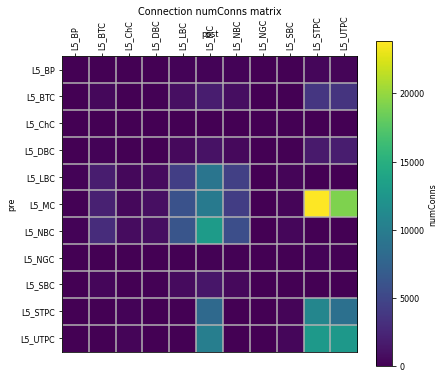

In [34]:
# features = ['numConns','convergence']
test = sim.analysis.plotConn(includePre=subPopLabels, includePost = subPopLabels, feature='numConns', figSize=(6, 6), fontSize=8, saveData=None, 
                               saveFig=True, showFig=False);

In [35]:
test[1]['connMatrix'] # total of synapses [AMPA, NMDA] or [GABAA, GABAB]

array([[0.0000e+00, 2.6000e+01, 0.0000e+00, 0.0000e+00, 1.9600e+02,
        1.9800e+02, 1.8700e+02, 0.0000e+00, 0.0000e+00, 4.0800e+02,
        3.6000e+02],
       [5.2000e+01, 4.8000e+02, 9.0000e+01, 1.2000e+02, 1.0080e+03,
        1.8700e+03, 9.2000e+02, 0.0000e+00, 3.6000e+01, 3.7800e+03,
        3.5560e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8000e+01,
        3.3000e+01],
       [1.8000e+01, 2.0900e+02, 3.6000e+01, 4.8000e+01, 6.2700e+02,
        1.1880e+03, 6.5000e+02, 0.0000e+00, 4.5000e+01, 1.7280e+03,
        1.8840e+03],
       [2.0400e+02, 1.9040e+03, 4.8100e+02, 7.2000e+02, 4.3960e+03,
        9.2820e+03, 4.4980e+03, 4.5000e+01, 3.5100e+02, 0.0000e+00,
        0.0000e+00],
       [1.2000e+02, 2.1670e+03, 5.4000e+02, 1.0220e+03, 5.9640e+03,
        9.6690e+03, 4.3500e+03, 4.5000e+01, 3.3300e+02, 2.3800e+04,
        1.9227e+04],
       [2.5900e+02, 3.0240e+03, 7.8200e+02, 8.6400e+02, 6.

In [36]:
###### connNumber = connData['connNumber']
synperconnNumber = connData['synperconnNumber']

i=0
for pre in subPopLabels:
    j=0
    for post in subPopLabels:
        connBBP = float(connNumber[pre][post])
        if connBBP>0:
            synperconn = int(synperconnNumber[pre][post]+0.5)
            connNetPyNE = test[1]['connMatrix'][i][j]/(1*synperconn)
#             if pre in Epops and post not in Epops:
            if connNetPyNE < 1:
                print('\t%s->%s  \t - \t  BBP = %5.1f   \t    NetPyNE = %5.1f  \t   Error = %5.1f' % (pre,post,connBBP,connNetPyNE,100*(connNetPyNE-connBBP)/connBBP),'%')

        j+=1
    i+=1

	L5_LBC->L5_STPC  	 - 	  BBP = 857.1   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_LBC->L5_UTPC  	 - 	  BBP = 874.4   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_NBC->L5_STPC  	 - 	  BBP = 869.9   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_NBC->L5_UTPC  	 - 	  BBP = 883.4   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_SBC->L5_SBC  	 - 	  BBP =   3.6   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_SBC->L5_STPC  	 - 	  BBP =  88.0   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_SBC->L5_UTPC  	 - 	  BBP =  81.0   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_STPC->L5_BP  	 - 	  BBP =  46.7   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_STPC->L5_BTC  	 - 	  BBP = 171.9   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_STPC->L5_DBC  	 - 	  BBP =  98.3   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_STPC->L5_LBC  	 - 	  BBP = 415.3   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_STPC->L5_NBC  	 - 	  BBP = 423.3   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_UTPC->L5_BP  	

Plotting 2D representation of network cell locations and connections...


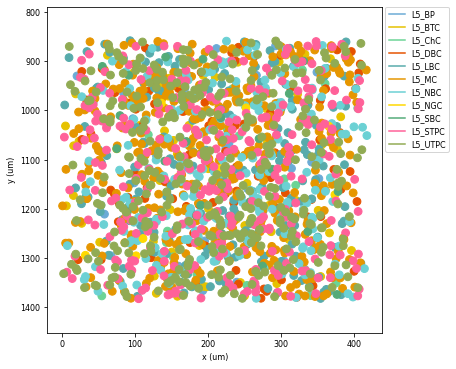

In [37]:
sim.analysis.plot2Dnet(include=subPopLabels,view='xy', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(6, 6), fontSize=8, saveData=None, 
                               saveFig=True, showFig=True, lineWidth=0.1);

Plotting 2D representation of network cell locations and connections...


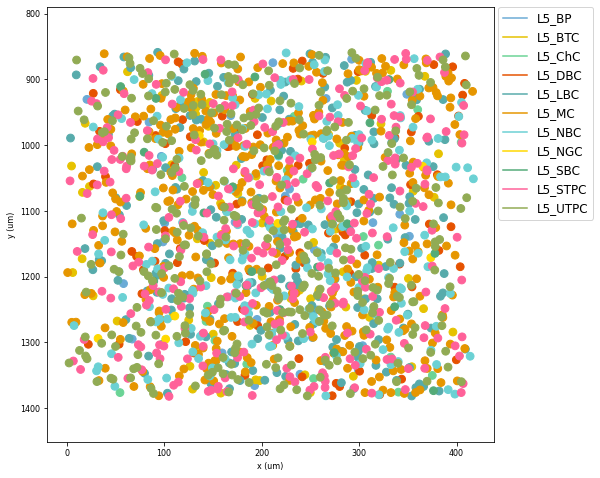

Plotting 2D representation of network cell locations and connections...


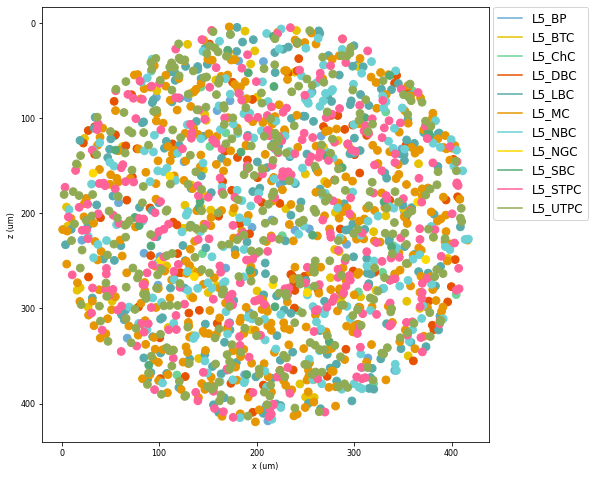

In [38]:
sim.analysis.plot2Dnet(include=subPopLabels,view='xy', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=subPopLabels,view='xz', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

## Raster and traces

In [39]:
sim.analysis.plotRaster(include=subPopLabels, timeRange=[0,cfg.duration], orderBy='y', orderInverse=True, labels='legend', popRates=True, lw=5, marker='.', markerSize=24, figSize=(12, 6), fontSize=20, dpi=500, saveFig=True, showFig=False);

Plotting raster...
No spikes available to plot raster


In [40]:
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:
        print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])     

L5_BP_bAC217 3 L5_BP 34
L5_BP_bIR215 5 L5_BP 34
L5_BP_bNAC219 9 L5_BP 34
L5_BP_cACint209 9 L5_BP 34
L5_BP_cNAC187 5 L5_BP 34
L5_BP_dSTUT214 3 L5_BP 34
L5_BTC_bAC217 13 L5_BTC 76
L5_BTC_cACint209 50 L5_BTC 76
L5_BTC_cNAC187 13 L5_BTC 76
L5_ChC_cACint209 7 L5_ChC 19
L5_ChC_cNAC187 7 L5_ChC 19
L5_ChC_dNAC222 5 L5_ChC 19
L5_DBC_bAC217 9 L5_DBC 96
L5_DBC_bIR215 34 L5_DBC 96
L5_DBC_bNAC219 9 L5_DBC 96
L5_DBC_bSTUT213 9 L5_DBC 96
L5_DBC_cACint209 9 L5_DBC 96
L5_DBC_cIR216 17 L5_DBC 96
L5_DBC_cNAC187 9 L5_DBC 96
L5_LBC_bAC217 12 L5_LBC 210
L5_LBC_cACint209 25 L5_LBC 210
L5_LBC_cIR216 13 L5_LBC 210
L5_LBC_cNAC187 37 L5_LBC 210
L5_LBC_cSTUT189 37 L5_LBC 210
L5_LBC_dNAC222 37 L5_LBC 210
L5_LBC_dSTUT214 49 L5_LBC 210
L5_MC_bAC217 145 L5_MC 395
L5_MC_bIR215 44 L5_MC 395
L5_MC_bSTUT213 16 L5_MC 395
L5_MC_cACint209 142 L5_MC 395
L5_MC_cNAC187 16 L5_MC 395
L5_MC_cSTUT189 16 L5_MC 395
L5_MC_dNAC222 16 L5_MC 395
L5_NBC_bAC217 14 L5_NBC 201
L5_NBC_bIR215 14 L5_NBC 201
L5_NBC_bSTUT213 27 L5_NBC 201
L5_NBC

In [41]:
traces = [(mtype, [i for i in range(0,cfg.popNumber[mtype],int(cfg.popNumber[mtype]/4.5))]) for mtype in subPopLabels]
traces

[('L5_BP', [0, 7, 14, 21, 28]),
 ('L5_BTC', [0, 16, 32, 48, 64]),
 ('L5_ChC', [0, 4, 8, 12, 16]),
 ('L5_DBC', [0, 21, 42, 63, 84]),
 ('L5_LBC', [0, 46, 92, 138, 184]),
 ('L5_MC', [0, 87, 174, 261, 348]),
 ('L5_NBC', [0, 44, 88, 132, 176]),
 ('L5_NGC', [0, 1, 2, 3, 4, 5, 6, 7]),
 ('L5_SBC', [0, 5, 10, 15, 20]),
 ('L5_STPC', [0, 67, 134, 201, 268]),
 ('L5_UTPC', [0, 76, 152, 228, 304])]

In [42]:
sim.analysis.plotTraces(include=traces, timeRange=[0,cfg.duration], overlay=False, oneFigPer='trace', ylim=[-90,50], subtitles= False, axis=False, scaleBarLoc=1, figSize=(12, 8), fontSize=12, saveFig=True);

Plotting recorded cell traces ... trace


<Figure size 864x576 with 0 Axes>

In [43]:
subPopLabels

['L5_BP',
 'L5_BTC',
 'L5_ChC',
 'L5_DBC',
 'L5_LBC',
 'L5_MC',
 'L5_NBC',
 'L5_NGC',
 'L5_SBC',
 'L5_STPC',
 'L5_UTPC']

Plotting recorded cell traces ... trace


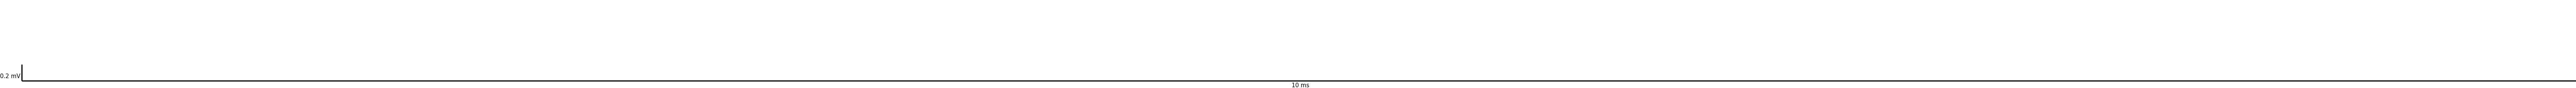

Plotting recorded cell traces ... trace


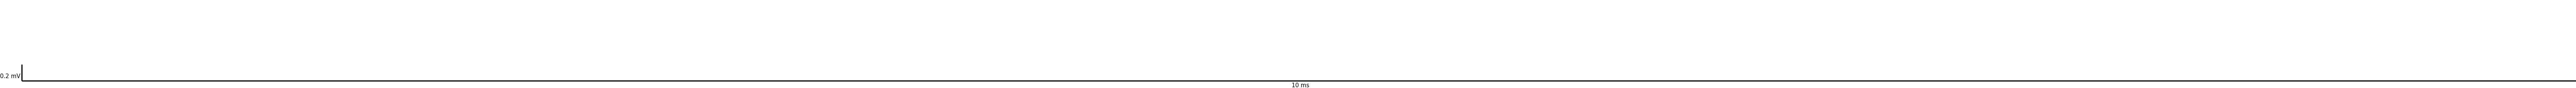

Plotting recorded cell traces ... trace


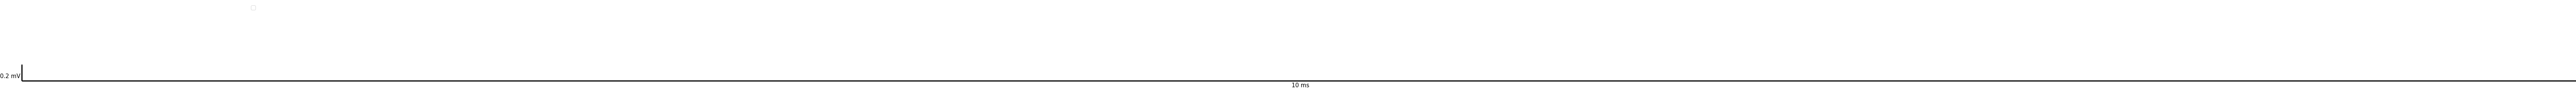

Plotting recorded cell traces ... trace


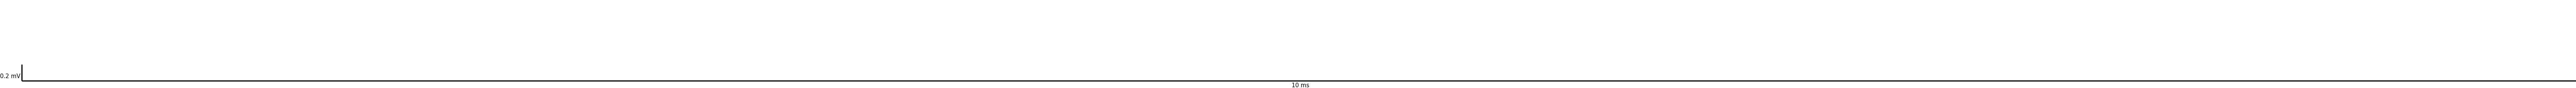

Plotting recorded cell traces ... trace


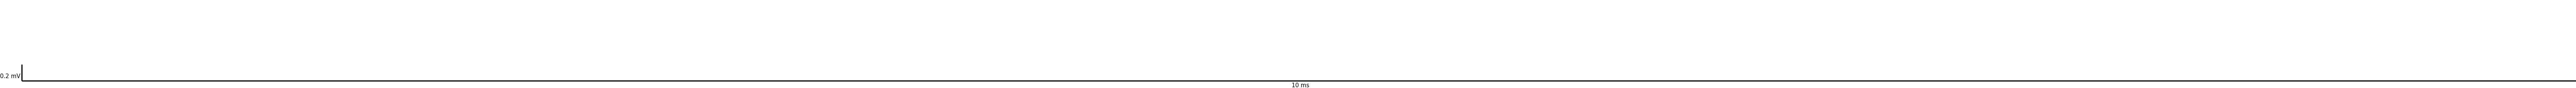

Plotting recorded cell traces ... trace


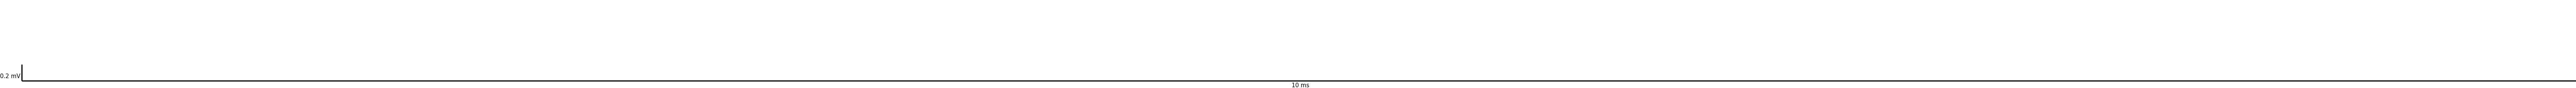

Plotting recorded cell traces ... trace


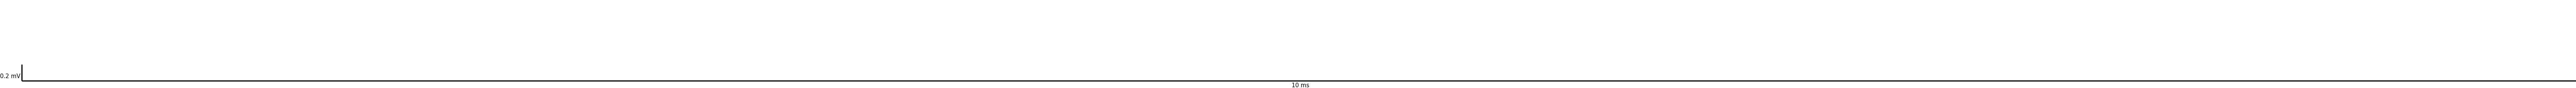

Plotting recorded cell traces ... trace


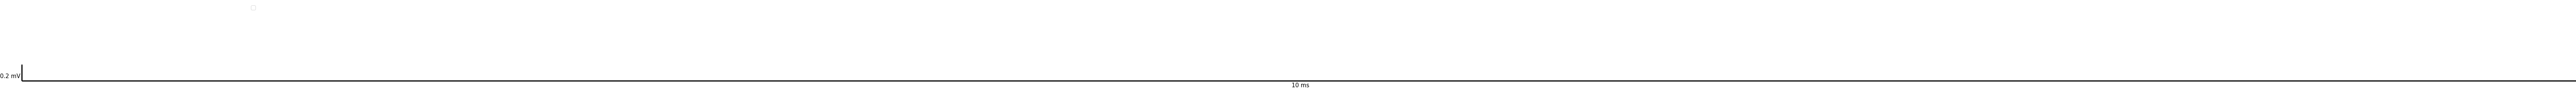

Plotting recorded cell traces ... trace


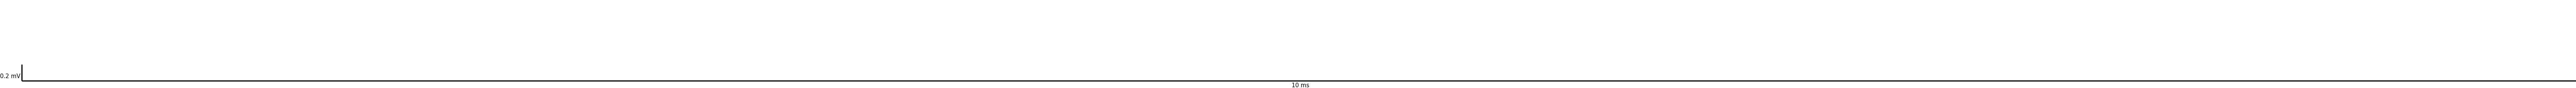

Plotting recorded cell traces ... trace


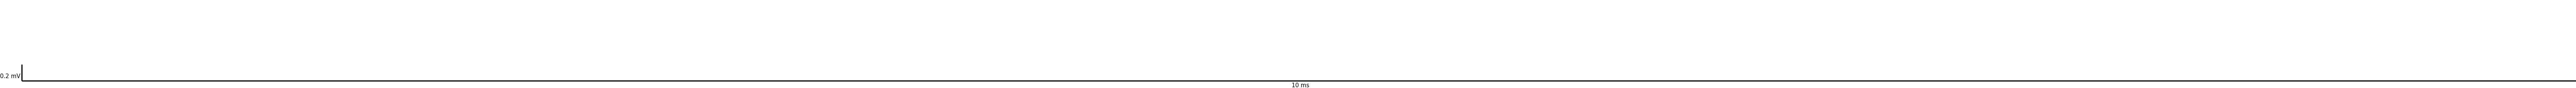

Plotting recorded cell traces ... trace


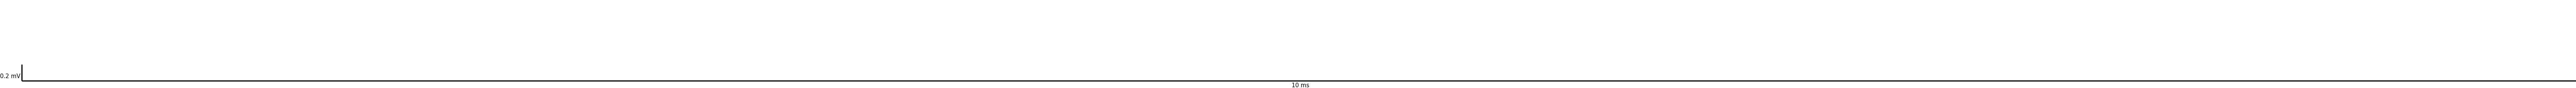

In [44]:
for pops in subPopLabels:
    sim.analysis.plotTraces(include=[pops], timeRange=[0,cfg.duration], overlay=True, oneFigPer='trace', ylim=[-80,50], axis=False, scaleBarLoc=3, figSize=(12, 4), fontSize=15, saveFig='../info/test/'+cfg.simLabel+'/'+cfg.simLabel +'_'+pops+ '_Vt.png');

In [57]:
for i in range(100):
    print(i,np.size(sim.net.cells[i].secLists['all']))

0 65
1 65
2 65
3 65
4 65
5 65
6 65
7 65
8 65
9 65
10 65
11 65
12 65
13 65
14 65
15 65
16 65
17 65
18 65
19 65
20 65
21 65
22 65
23 65
24 65
25 65
26 65
27 65
28 65
29 65
30 65
31 65
32 65
33 65
34 46
35 46
36 46
37 136
38 136
39 136
40 112
41 112
42 138
43 138
44 138
45 134
46 134
47 46
48 46
49 46
50 46
51 46
52 46
53 46
54 46
55 46
56 46
57 136
58 136
59 136
60 136
61 136
62 136
63 136
64 136
65 136
66 136
67 112
68 112
69 112
70 112
71 112
72 112
73 112
74 112
75 112
76 112
77 138
78 138
79 138
80 138
81 138
82 138
83 138
84 138
85 138
86 138
87 134
88 134
89 134
90 134
91 134
92 134
93 134
94 134
95 134
96 134
97 46
98 46
99 46


In [46]:
cellsID

{'L5_BP_bAC217': [0, 1, 2],
 'L5_BP_bIR215': [3, 4, 5, 6, 7],
 'L5_BP_bNAC219': [8, 9, 10, 11, 12, 13, 14, 15, 16],
 'L5_BP_cACint209': [17, 18, 19, 20, 21, 22, 23, 24, 25],
 'L5_BP_cNAC187': [26, 27, 28, 29, 30],
 'L5_BP_dSTUT214': [31, 32, 33],
 'L5_BTC_bAC217': [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46],
 'L5_BTC_cACint209': [47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96],
 'L5_BTC_cNAC187': [97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109],
 'L5_ChC_cACint209': [110, 111, 112, 113, 114, 115, 116],
 'L5_ChC_cNAC187': [117, 118, 119, 120, 121, 122, 123],
 'L5_ChC_dNAC222': [124, 125, 126, 127, 128],
 'L5_DBC_bAC217': [129, 130, 131, 132, 133, 134, 135, 136, 137],
 'L5_DBC_bIR215': [138,
  13

In [82]:
netParams.cellParams[cellMe]['secs']['soma']['mechs']['CaDynamics_E2']['decay']

210.485284

In [87]:
## S1 cell property rules
number = 0    
for cellName in cfg.S1cells:
    
    if cfg.cellNumber[cellName] < 5:
        morphoNumbers = cfg.cellNumber[cellName]
    else:
        morphoNumbers = 5
    
    popName = cfg.popLabel[cellName]
    cellFraction = 1.0*cfg.cellNumber[cellName]/(morphoNumbers*cfg.popNumber[popName])
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cellName + '_' + str(morphoNumber+1)
        for i in range(int(cfg.cellNumber[cellName]/morphoNumbers)):
            print(number,cellMe,netParams.cellParams[cellMe]['secs']['soma']['mechs']['CaDynamics_E2']['decay']-sim.net.cells[number].secs['soma']['mechs']['CaDynamics_E2']['decay'])
            number += 1    

0 L5_BP_bAC217_1 0.0
1 L5_BP_bAC217_2 0.0
2 L5_BP_bAC217_3 0.0
3 L5_BP_bIR215_1 0.0
4 L5_BP_bIR215_2 0.0
5 L5_BP_bIR215_3 0.0
6 L5_BP_bIR215_4 0.0
7 L5_BP_bIR215_5 0.0
8 L5_BP_bNAC219_1 0.0
9 L5_BP_bNAC219_2 0.0
10 L5_BP_bNAC219_3 0.0
11 L5_BP_bNAC219_4 0.0
12 L5_BP_bNAC219_5 0.0
13 L5_BP_cACint209_1 322.59904800000004
14 L5_BP_cACint209_2 322.59904800000004
15 L5_BP_cACint209_3 322.59904800000004
16 L5_BP_cACint209_4 322.59904800000004
17 L5_BP_cACint209_5 0.0
18 L5_BP_cNAC187_1 -235.97115200000007
19 L5_BP_cNAC187_2 -235.97115200000007
20 L5_BP_cNAC187_3 -235.97115200000007
21 L5_BP_cNAC187_4 -235.97115200000007
22 L5_BP_cNAC187_5 -235.97115200000007
23 L5_BP_dSTUT214_1 -235.97115200000007
24 L5_BP_dSTUT214_2 -235.97115200000007
25 L5_BP_dSTUT214_3 -235.97115200000007
26 L5_BTC_bAC217_1 -126.67441499999995
27 L5_BTC_bAC217_1 -126.67441499999995
28 L5_BTC_bAC217_2 -126.67441499999995
29 L5_BTC_bAC217_2 -126.67441499999995
30 L5_BTC_bAC217_3 -126.67441499999995
31 L5_BTC_bAC217_3 -126.

1244 L5_STPC_cADpyr232_5 0.0
1245 L5_STPC_cADpyr232_5 0.0
1246 L5_STPC_cADpyr232_5 0.0
1247 L5_STPC_cADpyr232_5 0.0
1248 L5_STPC_cADpyr232_5 0.0
1249 L5_STPC_cADpyr232_5 0.0
1250 L5_STPC_cADpyr232_5 0.0
1251 L5_STPC_cADpyr232_5 0.0
1252 L5_STPC_cADpyr232_5 0.0
1253 L5_STPC_cADpyr232_5 0.0
1254 L5_STPC_cADpyr232_5 0.0
1255 L5_STPC_cADpyr232_5 0.0
1256 L5_STPC_cADpyr232_5 0.0
1257 L5_STPC_cADpyr232_5 0.0
1258 L5_STPC_cADpyr232_5 0.0
1259 L5_STPC_cADpyr232_5 0.0
1260 L5_STPC_cADpyr232_5 0.0
1261 L5_STPC_cADpyr232_5 0.0
1262 L5_STPC_cADpyr232_5 0.0
1263 L5_STPC_cADpyr232_5 0.0
1264 L5_UTPC_cADpyr232_1 0.0
1265 L5_UTPC_cADpyr232_1 0.0
1266 L5_UTPC_cADpyr232_1 0.0
1267 L5_UTPC_cADpyr232_1 0.0
1268 L5_UTPC_cADpyr232_1 0.0
1269 L5_UTPC_cADpyr232_1 0.0
1270 L5_UTPC_cADpyr232_1 0.0
1271 L5_UTPC_cADpyr232_1 0.0
1272 L5_UTPC_cADpyr232_1 0.0
1273 L5_UTPC_cADpyr232_1 0.0
1274 L5_UTPC_cADpyr232_1 0.0
1275 L5_UTPC_cADpyr232_1 0.0
1276 L5_UTPC_cADpyr232_1 0.0
1277 L5_UTPC_cADpyr232_1 0.0
1278 L5_UTPC_c

In [64]:
np.size(sim.net.cells[i].secLists['all'])
np.size(netParams.cellParams[cellMe]['secLists']['all'])

46